In [23]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.special import expit
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter

sns.set(style="darkgrid")

In [24]:
file_path = "PremierLeague.csv"

# Load the data from Kaggle
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "ajaxianazarenka/premier-league",
  file_path,
)

In [25]:
# Create a dataframe for each team's home games
home = df.rename(columns={
    "HomeTeam": "Team",
    "AwayTeam": "Opponent",
    "FullTimeHomeTeamGoals": "GF",
    "FullTimeAwayTeamGoals": "GA"
})[["MatchID", "Season", "MatchWeek", "Team", "Opponent", "GF", "GA"]]

# Create a dataframe for each team's away games
away = df.rename(columns={
    "AwayTeam": "Team",
    "HomeTeam": "Opponent",
    "FullTimeAwayTeamGoals": "GF",
    "FullTimeHomeTeamGoals": "GA"
})[["MatchID", "Season", "MatchWeek", "Team", "Opponent", "GF", "GA"]]

# Combine home and away results so you have every team's every game accounted for
allMatches = pd.concat([home, away])

# Calculate goal difference and create a new dataframe for season-wide totals
allMatches["GD"] = allMatches["GF"] - allMatches["GA"]
teamResults = allMatches.groupby(["Season", "Team"], as_index=False).agg(
    GF = ("GF", "sum"),
    GA = ("GA", "sum"),
    G = ("MatchWeek", "count"),
    W = ("GD", lambda x: (x > 0).sum()),
    D = ("GD", lambda x: (x == 0).sum()),
)

# Calculate the total points for each team
teamResults["P"] = (3 * teamResults["W"] + 1 * teamResults["D"])
# Calculate the ratio of goals and then use log to smooth into a linear relationship
teamResults["GR"] = np.log((teamResults["GF"] / teamResults["GA"]))

In [26]:
x = teamResults["GR"].to_numpy(dtype=float) # Ratio of Goals For vs. Goals Against
s = teamResults["P"].to_numpy(dtype=float) # Points Earned
n = (3 * teamResults["G"]).to_numpy(dtype=float) # Total Points Available

# Implements the negative log-likelihood model
def nll(params):
    alpha, k = params
    # Implements the sigmoid function for logistic regression with the linear predictor and link function
    p = expit(alpha + k * x)
    # Prevents undefined log(0)
    eps = 1e-12
    p = np.clip(p, eps, 1 - eps)
    # binomial log likelihood
    return -(s * np.log(p) + (n - s) * np.log(1 - p)).sum()

# Minimizes the nll to maximize likelihood and find the best coefficients for the fit of the line
res = minimize(nll, x0=np.array([0.0, 1.0]), method="BFGS")

# Returns the coefficients needed
alpha, k = res.x
c = np.exp(alpha)

print("converged =", res.success, "|", res.message)
print("alpha =", alpha)
print("k     =", k)

converged = True | Optimization terminated successfully.
alpha = -0.16786731341479072
k     = 1.2095798373742814


In [27]:
# Calculates the expected points and error
teamResults["xP"] = (c * teamResults["GF"]**k / (c * teamResults["GF"]**k + teamResults["GA"]**k)) * 3 * teamResults["G"]
teamResults["error"] = teamResults["xP"] - teamResults["P"]

# Puts the results needed into a clean dataframe to print and easily interpret
cleanResults = teamResults[["Season", "Team", "P", "xP", "error"]].copy()

print(cleanResults.tail(20))

        Season            Team   P         xP      error
624  2024-2025         Arsenal  74  75.874770   1.874770
625  2024-2025     Aston Villa  66  56.649616  -9.350384
626  2024-2025     Bournemouth  56  60.203306   4.203306
627  2024-2025       Brentford  56  57.269645   1.269645
628  2024-2025        Brighton  61  56.080884  -4.919116
629  2024-2025         Chelsea  69  65.852884  -3.147116
630  2024-2025  Crystal Palace  53  52.226985  -0.773015
631  2024-2025         Everton  48  50.638705   2.638705
632  2024-2025          Fulham  54  52.226985  -1.773015
633  2024-2025         Ipswich  22  27.133697   5.133697
634  2024-2025       Leicester  25  25.606081   0.606081
635  2024-2025       Liverpool  84  76.881743  -7.118257
636  2024-2025        Man City  71  69.010303  -1.989697
637  2024-2025      Man United  42  45.323470   3.323470
638  2024-2025       Newcastle  66  64.897614  -1.102386
639  2024-2025   Nott'm Forest  65  60.203306  -4.796694
640  2024-2025     Southampton 

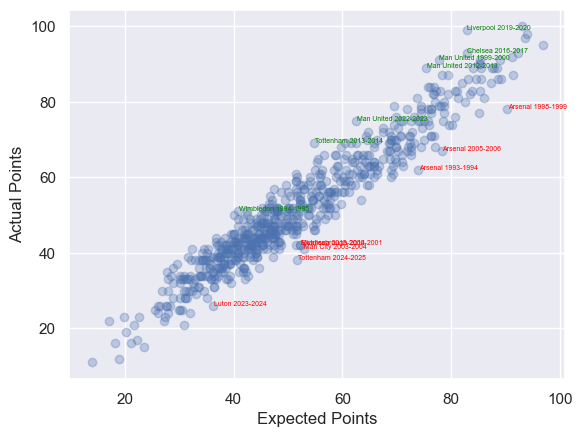

In [28]:
# Plot results in a scattergram 
x = cleanResults["xP"]
y = cleanResults["P"]

plt.scatter(x, y, alpha=0.3)

plt.xlabel("Expected Points")
plt.ylabel("Actual Points")
for row in cleanResults.itertuples(index=False):
    if (row.error > 10):
        plt.text(row.xP+0.1, row.P+0.1, f"{row.Team} {row.Season}", fontsize=5, color="red");
    elif (row.error < -10):
        plt.text(row.xP+0.1, row.P+0.1, f"{row.Team} {row.Season}", fontsize=5, color="green");

plt.show()

In [29]:
# Calculate mean absolute error, root mean squared deviation, and bias 
MAE = cleanResults["error"].abs().mean()
RMSE = np.sqrt((cleanResults["error"]**2).mean())
bias = cleanResults["error"].mean()
print("MAE:", MAE)
print("RMSE:", RMSE)
print("Bias:", bias)

MAE: 3.587465618282301
RMSE: 4.479626707412388
Bias: -2.385288148641097e-07
